# Importing Necessary Libraries

In [1]:
from pyspark.sql import SparkSession
from hdfs import InsecureClient
import cv2
import tempfile
import uuid
import numpy as np
import io, os, subprocess
import matplotlib.pyplot as plt
from scipy.signal import wiener

# Initialize Spark Session
### Initialize Spark session

In [2]:
spark = SparkSession.builder \
    .appName("ImageProcessing") \
    .getOrCreate()

24/02/09 11:55:27 WARN Utils: Your hostname, kira resolves to a loopback address: 127.0.1.1; using 100.97.209.177 instead (on interface wlp2s0)
24/02/09 11:55:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/09 11:55:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# List Videos in HDFS Directory

In [3]:
def list_files_in_hdfs(directory):
    proc = subprocess.Popen(['hdfs', 'dfs', '-ls', directory], stdout=subprocess.PIPE)
    output = proc.communicate()[0].decode('utf-8')  # Decode bytes to string
    files = []
    for line in output.split('\n'):
        parts = line.split()
        print(parts)

        if len(parts) > 7:
            files.append(parts[7])
    return files

In [4]:
video_files = list_files_in_hdfs('/student_videos')
print(video_files)

['Found', '5', 'items']
['-rw-r--r--', '1', 'hdfs', 'supergroup', '8942908', '2024-01-14', '12:17', '/student_videos/video-32a7c9e2-13b5-485f-ab19-d8c07081cb35.mp4']
['-rw-r--r--', '1', 'hdfs', 'supergroup', '8942908', '2024-01-14', '00:06', '/student_videos/video-624df084-19a3-4bbf-8fe4-ba1f0d1c09d6.mp4']
['-rw-r--r--', '1', 'hdfs', 'supergroup', '5898216', '2024-01-14', '12:17', '/student_videos/video-68108ec1-7cf0-4bc0-b843-958c33234597.mp4']
['-rw-r--r--', '1', 'hdfs', 'supergroup', '4', '2024-01-14', '00:07', '/student_videos/video-76e4d3a2-82d2-4679-b6d2-75ac5004484c.mp4']
['-rw-r--r--', '1', 'hdfs', 'supergroup', '5898216', '2024-01-14', '00:07', '/student_videos/video-f2c1c7c6-455c-4a43-8a2b-4a74065c18a3.mp4']
[]
['/student_videos/video-32a7c9e2-13b5-485f-ab19-d8c07081cb35.mp4', '/student_videos/video-624df084-19a3-4bbf-8fe4-ba1f0d1c09d6.mp4', '/student_videos/video-68108ec1-7cf0-4bc0-b843-958c33234597.mp4', '/student_videos/video-76e4d3a2-82d2-4679-b6d2-75ac5004484c.mp4', '/st

# Download Video from HDFS

In [5]:
def download_videos_from_hdfs(hdfs_files, local_dir):
    """
    Download video files from HDFS to the local directory, only if they don't already exist.
    :param hdfs_files: List of HDFS file paths.
    :param local_dir: Local directory to store the videos.
    """
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)

    for hdfs_file in hdfs_files:
        local_file = os.path.join(local_dir, os.path.basename(hdfs_file))
        if not os.path.exists(local_file):
            print(f"Downloading {hdfs_file} to {local_file}")
            subprocess.run(['hdfs', 'dfs', '-get', hdfs_file, local_file], check=True)
        else:
            print(f"File {local_file} already exists. Skipping download.")

# Extract Frames from Videos

In [6]:
def extract_frames(video_path, num_frames):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = total_frames // num_frames
    
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    return frames

In [7]:
download_videos_from_hdfs(video_files, 'videos')

File videos/video-32a7c9e2-13b5-485f-ab19-d8c07081cb35.mp4 already exists. Skipping download.
File videos/video-624df084-19a3-4bbf-8fe4-ba1f0d1c09d6.mp4 already exists. Skipping download.
File videos/video-68108ec1-7cf0-4bc0-b843-958c33234597.mp4 already exists. Skipping download.
File videos/video-76e4d3a2-82d2-4679-b6d2-75ac5004484c.mp4 already exists. Skipping download.
File videos/video-f2c1c7c6-455c-4a43-8a2b-4a74065c18a3.mp4 already exists. Skipping download.


# Read content in the videos directory

In [8]:
def read_videos_from_dir(directory):
    videos = []
    for file in os.listdir(directory):
        if file.endswith(".mp4"):
            videos.append(os.path.join(directory, file))
    return videos

videos = read_videos_from_dir('videos')
print(videos)

['videos/video-624df084-19a3-4bbf-8fe4-ba1f0d1c09d6.mp4', 'videos/video-f2c1c7c6-455c-4a43-8a2b-4a74065c18a3.mp4', 'videos/video-32a7c9e2-13b5-485f-ab19-d8c07081cb35.mp4', 'videos/video-68108ec1-7cf0-4bc0-b843-958c33234597.mp4', 'videos/video-76e4d3a2-82d2-4679-b6d2-75ac5004484c.mp4']


In [9]:
def display_images(images, titles=None, rows=2, cols=3, figsize=(15, 10)):
    """Display multiple images in a grid."""
    if titles is None:
        titles = [''] * len(images)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(titles[i])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
num_frames = 6
frames = extract_frames(videos[3], num_frames)

## Display the images

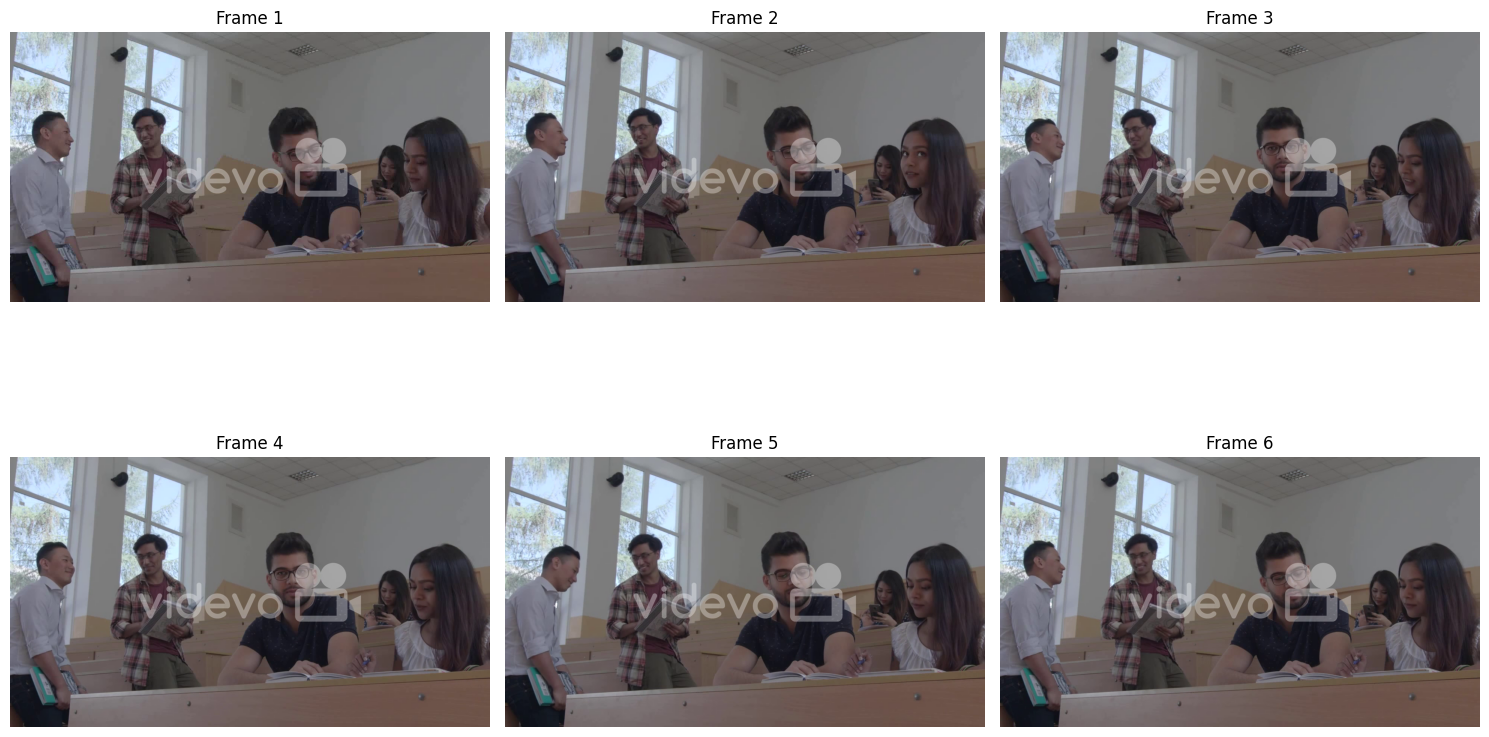

In [11]:
# Display the frames
display_images(frames, titles=[f'Frame {i + 1}' for i in range(num_frames)])

# Application des techniques de traitement d'images

In [12]:
# Convert the frames to grayscale
def convert_to_grayscale(image):
    """Convert an image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Égalisation de l'histogramme
def equalize_histogram(image):
    """Equalize the histogram of a grayscale image."""
    # Séparer les canaux de couleur
    canal_b, canal_g, canal_r = cv2.split(image)

    # Appliquer l'égalisation d'histogramme à chaque canal de couleur
    canal_b_eq = cv2.equalizeHist(canal_b)
    canal_g_eq = cv2.equalizeHist(canal_g)
    canal_r_eq = cv2.equalizeHist(canal_r)

    # Fusionner les canaux de couleur égalisés
    image_eq = cv2.merge((canal_b_eq, canal_g_eq, canal_r_eq))

    return image_eq

# Appliquer un filtre gaussien avec un noyau de taille 5x5
def apply_gaussian_blur(image, ksize=5):
    """Apply a Gaussian blur to the image."""
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

# Apply laplacian filter
def apply_laplacian(image):
    # Split the image into its color channels
    b, g, r = cv2.split(image)

    # Apply Laplacian filter to each channel
    b_lap = cv2.Laplacian(b, cv2.CV_64F)
    g_lap = cv2.Laplacian(g, cv2.CV_64F)
    r_lap = cv2.Laplacian(r, cv2.CV_64F)

    # Convert back to uint8
    b_lap = np.uint8(np.absolute(b_lap))
    g_lap = np.uint8(np.absolute(g_lap))
    r_lap = np.uint8(np.absolute(r_lap))

    # Merge the sharpened channels
    sharpened = cv2.merge((b_lap, g_lap, r_lap))

    return sharpened

# Apply Sobel filter
def apply_sobel_filter(image):
    # Split the image into its color channels
    b, g, r = cv2.split(image)

    # Apply Sobel filter to each channel
    b_sobel_x = cv2.Sobel(b, cv2.CV_64F, 1, 0, ksize=3)
    b_sobel_y = cv2.Sobel(b, cv2.CV_64F, 0, 1, ksize=3)
    g_sobel_x = cv2.Sobel(g, cv2.CV_64F, 1, 0, ksize=3)
    g_sobel_y = cv2.Sobel(g, cv2.CV_64F, 0, 1, ksize=3)
    r_sobel_x = cv2.Sobel(r, cv2.CV_64F, 1, 0, ksize=3)
    r_sobel_y = cv2.Sobel(r, cv2.CV_64F, 0, 1, ksize=3)

    # Convert back to uint8
    b_sobel_x = np.uint8(np.absolute(b_sobel_x))
    b_sobel_y = np.uint8(np.absolute(b_sobel_y))
    g_sobel_x = np.uint8(np.absolute(g_sobel_x))
    g_sobel_y = np.uint8(np.absolute(g_sobel_y))
    r_sobel_x = np.uint8(np.absolute(r_sobel_x))
    r_sobel_y = np.uint8(np.absolute(r_sobel_y))

    # Merge the Sobel channels
    sobel = cv2.merge((b_sobel_x, g_sobel_y, r_sobel_x))

    return sobel

# Sharpen the image
def sharpen_image(image):
    # Create the sharpening kernel 
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 

    # Sharpen the image 
    sharpened_image = cv2.filter2D(image, -1, kernel)

    return sharpened_image

# Enhance RGB image quality
def enhance_rgb_quality(image):
    """Enhance the quality of an RGB image using histogram equalization."""
    # Convert image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    lab_image[:, :, 0] = clahe.apply(lab_image[:, :, 0])

    # Convert back to RGB color space
    enhanced_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    return enhanced_image

# Remove blur effect from RGB image
def remove_blur_effect(image):
    # Split the image into its color channels
    b, g, r = cv2.split(image)

    # Apply Wiener deconvolution to each color channel to deblur
    deblurred_b = wiener(b, (5, 5), 0.01)
    deblurred_g = wiener(g, (5, 5), 0.01)
    deblurred_r = wiener(r, (5, 5), 0.01)

    # Convert the deblurred images back to uint8
    deblurred_b = np.uint8(deblurred_b)
    deblurred_g = np.uint8(deblurred_g)
    deblurred_r = np.uint8(deblurred_r)

    # Merge the deblurred color channels
    deblurred = cv2.merge((deblurred_b, deblurred_g, deblurred_r))

    return deblurred


# Apply Mediane filter
def apply_median_filter(image, ksize=5):
    # Split the image into its color channels
    b, g, r = cv2.split(image)

    # Apply median blur to each color channel separately
    blurred_b = cv2.medianBlur(b, ksize)
    blurred_g = cv2.medianBlur(g, ksize)
    blurred_r = cv2.medianBlur(r, ksize)

    # Merge the blurred color channels
    blurred = cv2.merge((blurred_b, blurred_g, blurred_r))

    return blurred

# Adjusts the brightness by adding 10 to each pixel value 
def adjust_brightness(image, brightness=10, contrast=1.0):
    adjusted_image = cv2.addWeighted(image, contrast, np.zeros(image.shape, image.dtype), 0, brightness)
    return adjusted_image  

# Rotation
def rotate_image(image, angle=90, scale=1.0):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated_image = cv2.warpAffine(image, M, (w, h))
    return rotated_image

# Cropping
def crop_image(image, x, y, w, h):
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image

# Resize
def resize_image(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized_image = cv2.resize(image, dim, interpolation=inter)
    return resized_image

# Zooming
def zoom_image(image, zoom_factor=1.5):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, 0, zoom_factor)
    zoomed_image = cv2.warpAffine(image, M, (w, h))
    return zoomed_image

# Edge detection
def detect_edges(image):
    """Detect edges in the input image using the Canny Edge Detector."""
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Setting parameter values
    t_lower = 50  # Lower Threshold
    t_upper = 150  # Upper threshold

    # Applying the Canny Edge filter
    edge = cv2.Canny(gray_image, t_lower, t_upper)

    return edge

# Dilation
def dilate_image(image, ksize=5):
    kernel = np.ones((ksize, ksize), np.uint8)
    return cv2.dilate(image, kernel, iterations=1)

# Erosion
def erode_image(image, ksize=5):
    kernel = np.ones((ksize, ksize), np.uint8)
    return cv2.erode(image, kernel, iterations=1)

# Opening
def open_image(image, ksize=5):
    kernel = np.ones((ksize, ksize), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

# Closing
def close_image(image, ksize=5):
    kernel = np.ones((ksize, ksize), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

# Bilateral filter
def apply_bilateral_filter(image, d=3, sigmaColor=15, sigmaSpace=15):
    # Apply Bilateral Filter
    return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)

## Save the images in the HDFS directory

In [13]:
def save_image_to_hdfs(image, target_dir, operation_type, filename_prefix='result'):
    """
    Save the processed image to HDFS.

    Parameters:
    - image: The processed image (NumPy array).
    - target_dir: The target directory in HDFS.
    - operation_type: The type of operation applied to the image (e.g., rotation, cropping, enhancement).
    - filename_prefix: Prefix for the saved filename (default is 'result').

    Returns:
    - saved_filename: The filename under which the image is saved.
    """
    # HDFS Client
    hdfs_client = InsecureClient('http://localhost:9870', user='hdfs')

    # Check and create target directory if it doesn't exist
    if not hdfs_client.content(target_dir, strict=False):
        print(f"Creating directory: {target_dir}")
        hdfs_client.makedirs(target_dir, permission=777)

    # Define the filename based on the operation type
    saved_filename = f'{filename_prefix}_{operation_type}_{uuid.uuid4()}.png'

    # Save the image locally
    local_path = os.path.join(tempfile.gettempdir(), saved_filename)
    cv2.imwrite(local_path, image)

    # Write the image to HDFS
    with hdfs_client.write(f'{target_dir}/{saved_filename}', overwrite=True) as hdfs_file:
        with open(local_path, 'rb') as local_file:
            hdfs_file.write(local_file.read())

    return saved_filename

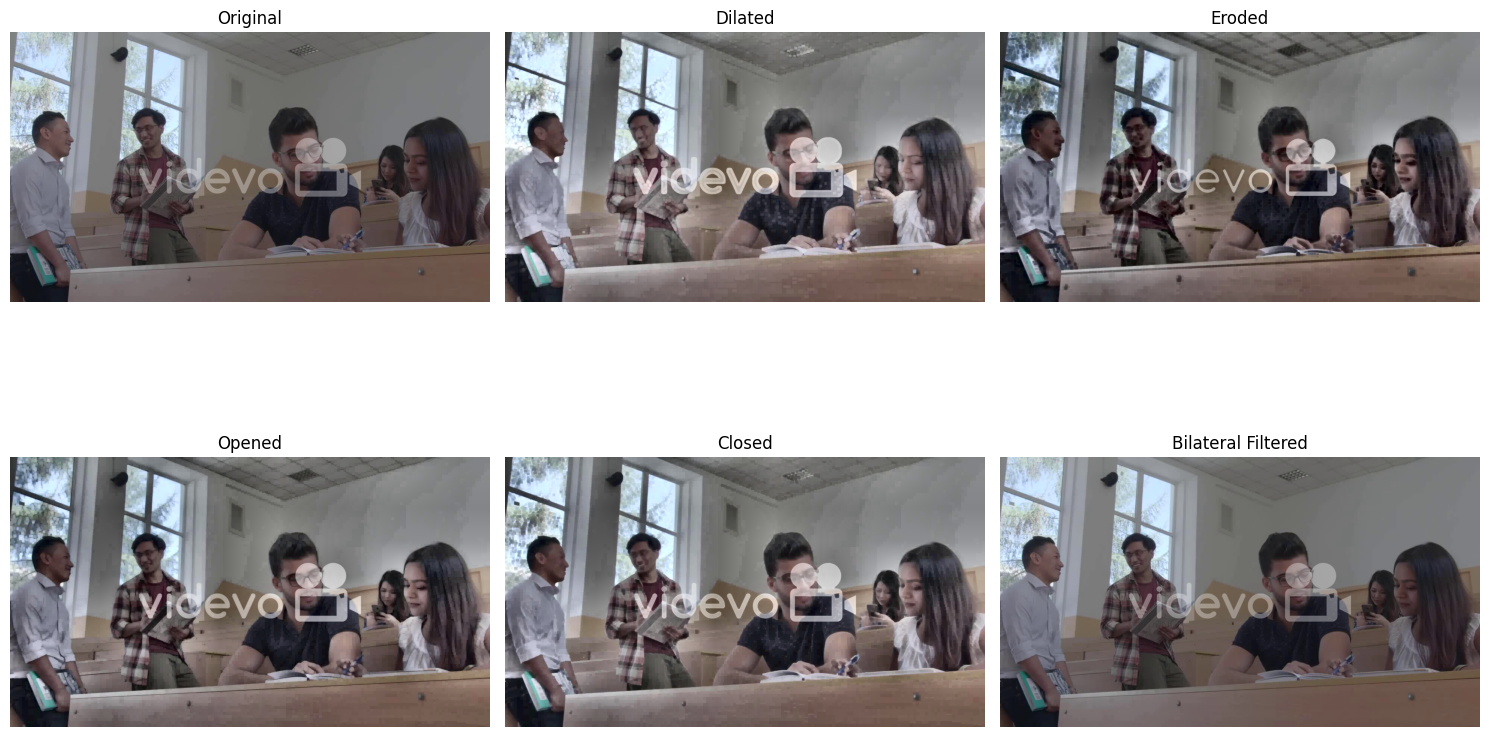

In [14]:
equalized_img = equalize_histogram(frames[0])
laplacian_sharpened = apply_laplacian(equalized_img)
enhanced_img = enhance_rgb_quality(frames[0])
adjusted_img = adjust_brightness(enhanced_img, brightness=10)
sobel_img = apply_sobel_filter(frames[0])
sharpened_image = sharpen_image(frames[0])
rotated_img = rotate_image(frames[0], angle=45)
cropped_img = crop_image(frames[0], 100, 100, 200, 200)
resized_img = resize_image(frames[0], width=1800)
zoomed_img = zoom_image(frames[0], zoom_factor=1.5)
edges_img = detect_edges(frames[0])
dilated_img = dilate_image(enhanced_img)
eroded_img = erode_image(enhanced_img)
opened_img = open_image(enhanced_img)
closed_img = close_image(enhanced_img)
bilateral_filtered_img = apply_bilateral_filter(frames[0])

# Save the processed images to HDFS
equalized_filename = save_image_to_hdfs(equalized_img, '/processed_images', 'equalized')
laplacian_sharpened_filename = save_image_to_hdfs(laplacian_sharpened, '/processed_images', 'laplacian_sharpened')
enhanced_filename = save_image_to_hdfs(enhanced_img, '/processed_images', 'enhanced')
adjusted_filename = save_image_to_hdfs(adjusted_img, '/processed_images', 'adjusted')
sobel_filename = save_image_to_hdfs(sobel_img, '/processed_images', 'sobel')
sharpened_filename = save_image_to_hdfs(sharpened_image, '/processed_images', 'sharpened')
rotated_filename = save_image_to_hdfs(rotated_img, '/processed_images', 'rotated')
cropped_filename = save_image_to_hdfs(cropped_img, '/processed_images', 'cropped')
resized_filename = save_image_to_hdfs(resized_img, '/processed_images', 'resized')

# blur_removed_img = remove_blur_effect(enhanced_img)
# median_blurred_img = apply_median_filter(frames[0], ksize=7)
# Display the processed images
display_images([frames[0], dilated_img, eroded_img, opened_img, closed_img, bilateral_filtered_img],
                titles=['Original', 'Dilated', 'Eroded', 'Opened', 'Closed', 'Bilateral Filtered'])